In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from scipy.stats import randint
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [2]:
def DealMissingData(X, dfX):
    ''' deal with missing data
        X: data, type(numpy array)
        dfX: same as X data, type(pandas array) '''
    
    print("----------- Start deal missing data -----------")
    TFarr = np.array(dfX.isna().any())
    for index, ele in enumerate(TFarr):
        if ele:
            if isinstance(X[0][index], str):
                # deal with string data
                imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
                imputer.fit(X[:, [index]])
                X[:, [index]] = imputer.transform(X[:, [index]])
            else:
                # deal with digital data
                imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
                imputer.fit(X[:, [index]])
                X[:, [index]] = imputer.transform(X[:, [index]])
            print(f"column {index} have missing data, fixed!")
        else:
            print(f"column {index} not have missing data")
            
    print("----------- End deal missing data! -----------")
    return X

In [3]:
def MakeOneHot(X, column_name, pos={}):
    ''' make one-hot  
        X: data, type(numpy array)
        pos: where need to onehot, type(dictionary) '''
    
    print("----------- Start onehot -----------")
    FeaturesNum = len(X[0])    # init
    if bool(pos):
        # custom onehot (onehot pos that u want to)
        for key in pos:
            print(f"{FeaturesNum-pos[key]} column need to one-hot, fixed!")
            ct = ColumnTransformer([(key, OneHotEncoder(), [FeaturesNum-pos[key]])], remainder='passthrough')
            NewX = ct.fit_transform(X)
            X = NewX[:, 1:]
            FeaturesNum = len(X[0])
    else:
        # auto onehot (only onehot string cols)
        i = 0
        cn = list(column_name)
        while i < FeaturesNum:
            if isinstance(X[0][i], str):
                print(f"{i} column need to one-hot, fixed!")
                label = cn.pop(i)
                print(label)
                ct = ColumnTransformer([(str(i), OneHotEncoder(), [i])], remainder='passthrough')
                ct_X = ct.fit_transform(X)
                NewX = ct_X[:, 1:]
                OneHotLabel = ct.named_transformers_[str(i)]
                for num in range(len(OneHotLabel.categories_[0])-1):
                    cn.insert(num,label+str(num+1))
                i += len(NewX[0]) - len(X[0])
                X = NewX
                FeaturesNum = len(X[0])
            i += 1
    print("----------- End onehot -----------")
    
    return X,cn

In [4]:
def NormalizeData(data_train, data_test):
    ''' normalize data
        data_train: training data, type(numpy array)
        data_test: testing data, type(numpy array) '''
    
    print("----------- Start normalize -----------")
    sc = StandardScaler()
    data_train = sc.fit_transform(data_train)
    data_test = sc.transform(data_test)
    
    print("----------- End normalize -----------")
    return data_train, data_test

In [6]:
def DrawPredict(gt, pred, title):
    ''' data [[groundTruth, predict], [], ....]'''
    
    data = []
    for i in range(len(gt)):
        data.append([gt[i], pred[i]])
        
    data.sort(key=lambda x:x[0])
    for index, ele in enumerate(data):
        plt.scatter(index, data[index][1], c="blue", s=0.7)
        plt.scatter(index, data[index][0], c="red", s=0.7)
    plt.xlabel("dataNums")
    plt.ylabel("charges")
    plt.title(title)
    plt.show() 

In [7]:
def TrainAndTestModel(model, X_train, y_train, X_test, y_test, title, want_fit_model=False):
    if want_fit_model:
        model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    train_acc = model.score(X_train, y_train)
    #train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    #DrawPredict(y_train, train_pred, title+"_Train" + "\n" + f"ACC: {train_acc}")
    
    test_pred = model.predict(X_test)
    test_acc = model.score(X_test, y_test)
    #test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    #DrawPredict(y_test, test_pred, title+"_Test" + "\n" + f"ACC: {test_acc}")
    
    train_cm = confusion_matrix(y_train, train_pred)
    test_cm = confusion_matrix(y_test, test_pred)
    print('train_cm: ','\n',train_cm,'\n')
    print('test_cm: ','\n',test_cm,'\n')
    print('train_acc: ',train_acc)
    print('test_acc: ',test_acc)
    train_cm_matrix = pd.DataFrame(data=train_cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
    test_cm_matrix = pd.DataFrame(data=test_cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
    
    
    
    return model,train_cm_matrix,test_cm_matrix

In [8]:
def show_cm(train_cm='',test_cm=''):
        sns.heatmap(train_cm, annot=True, fmt='d', cmap='viridis')

In [9]:
df = pd.read_csv("./dataset/final_project_dataset_2.csv")
df.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008/12/1,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008/12/2,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008/12/3,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008/12/4,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008/12/5,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [10]:
dfX = df.iloc[:, 1:-1]
X = dfX.values
dfy = df.iloc[:, [-1]]
y = dfy.values
X_column_name = np.array(dfX.columns.values)
y_column_name = np.array(dfy.columns.values)

X = DealMissingData(X, dfX)
y = DealMissingData(y, dfy)


print(X[0])
print(y[0])

X,X_column_name = MakeOneHot(X,X_column_name)
y,y_column_name = MakeOneHot(y,y_column_name)
y = y.reshape(1, -1)[0]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_test = NormalizeData(X_train, X_test)
print("----------- X column -----------")
for ele in zip(X[0], X_column_name):
    print(f"{ele[1]} : {ele[0]}")
print("----------- y column -----------")
for ele in zip(y, y_column_name):
    print(f"{ele[1]} : {ele[0]}")
print("Preprocessing data done!")

----------- Start deal missing data -----------
column 0 not have missing data
column 1 have missing data, fixed!
column 2 have missing data, fixed!
column 3 have missing data, fixed!
column 4 have missing data, fixed!
column 5 have missing data, fixed!
column 6 have missing data, fixed!
column 7 have missing data, fixed!
column 8 have missing data, fixed!
column 9 have missing data, fixed!
column 10 have missing data, fixed!
column 11 have missing data, fixed!
column 12 have missing data, fixed!
column 13 have missing data, fixed!
column 14 have missing data, fixed!
column 15 have missing data, fixed!
column 16 have missing data, fixed!
column 17 have missing data, fixed!
column 18 have missing data, fixed!
column 19 have missing data, fixed!
column 20 have missing data, fixed!
----------- End deal missing data! -----------
----------- Start deal missing data -----------
column 0 not have missing data
----------- End deal missing data! -----------
['Albury' 13.4 22.9 0.6 5.46982421634

<h1>LogisticRegression<\h1>

In [11]:
Logistic_model, Log_train_cm, Log_test_cm = TrainAndTestModel(LogisticRegression(random_state=42,verbose=1), X_train, y_train, X_test, y_test, "Logistic_classifier",want_fit_model=True)

[LibLinear]

C:\Users\john\copy\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


train_cm:  
 [[83439  4810]
 [12481 13024]] 

test_cm:  
 [[20887  1180]
 [ 3102  3270]] 

train_acc:  0.847996553967333
test_acc:  0.8494321178663103


Log_train


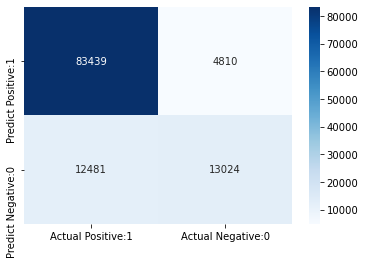

In [52]:
sns.heatmap(Log_train_cm, annot=True, fmt='d', cmap='Blues')
print('Log_train')

Log_test


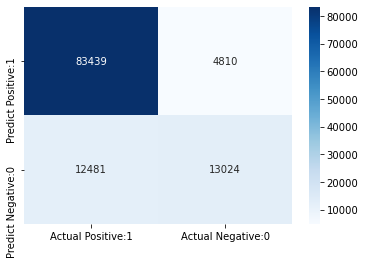

In [53]:
sns.heatmap(Log_train_cm, annot=True, fmt='d', cmap='Blues')
print('Log_test')

<h1>DecisionTree with Randomsearch<\h1>

In [22]:
param_distribs = {
    'min_samples_split': randint(low=100, high=200),
    'max_features': randint(low=70, high=95),
    'max_depth': randint(low=3, high=20),
    'min_samples_leaf': randint(low=40, high=50),
}

In [16]:
DecisionTree = DecisionTreeClassifier(criterion='entropy', random_state=0)
rnd_search = RandomizedSearchCV(DecisionTree, param_distributions=param_distribs,
                                n_iter=50, cv=3, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='entropy',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=0,
                                                    splitter='best')

In [26]:
rnd_search.best_params_

{'max_depth': 9,
 'max_features': 90,
 'min_samples_leaf': 42,
 'min_samples_split': 157}

In [27]:
feature_importances = rnd_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, X_column_name), reverse=True)

[(0.5752365605271297, 'Humidity3pm'),
 (0.09653587495514528, 'Pressure3pm'),
 (0.09536004345122795, 'Rainfall'),
 (0.08840122280211923, 'Sunshine'),
 (0.06959169245456913, 'WindGustSpeed'),
 (0.009948689669365702, 'Cloud3pm'),
 (0.009356712546038483, 'Temp9am'),
 (0.008556798048102759, 'Temp3pm'),
 (0.0076800839186155784, 'Humidity9am'),
 (0.00763141003702526, 'MinTemp'),
 (0.007041311343311371, 'RainToday1'),
 (0.004388473000769847, 'MaxTemp'),
 (0.0037790562742693245, 'Pressure9am'),
 (0.0024016630111238697, 'Location47'),
 (0.0022184057013437015, 'WindSpeed3pm'),
 (0.002151760580614191, 'Location26'),
 (0.001905922536959345, 'Location1'),
 (0.0018132481103412057, 'WindSpeed9am'),
 (0.0010903225172219397, 'Location16'),
 (0.0008669693810844798, 'WindGustDir4'),
 (0.0007289122708287809, 'Location23'),
 (0.000695972165037619, 'Evaporation'),
 (0.0005352383862839556, 'WindDir3pm13'),
 (0.00043400760235728746, 'Cloud9am'),
 (0.0002909651704806118, 'WindDir9am5'),
 (0.0002673307529826123,

In [28]:
Decision_rnd_search_model = rnd_search.best_estimator_
Decision_model, Decision_train_cm, Decision_test_cm = TrainAndTestModel(Decision_rnd_search_model, X_train, y_train, X_test, y_test, "DecisionTree_classifier")

train_cm:  
 [[83968  4281]
 [12990 12515]] 

test_cm:  
 [[20892  1175]
 [ 3308  3064]] 

train_acc:  0.8481723719605464
test_acc:  0.8423643588030522


Decision_train


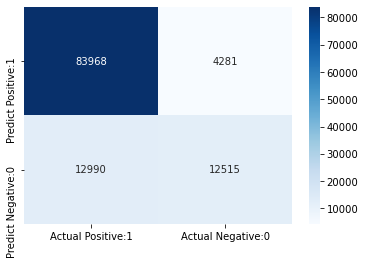

In [50]:
sns.heatmap(Decision_train_cm, annot=True, fmt='d', cmap='Blues')
print('Decision_train')

Decision_test


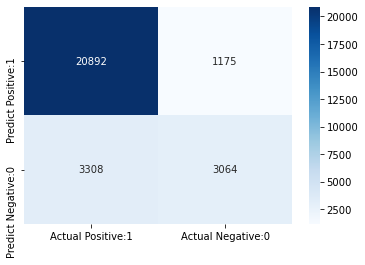

In [51]:
sns.heatmap(Decision_test_cm, annot=True, fmt='d', cmap='Blues')
print('Decision_test')

<h1>RandomForest with Random Search<\h1>

In [19]:
param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=107),
    'max_depth': randint(low=3, high=50),
    'min_samples_leaf': randint(low=5, high=50),
}

forest_classifier = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=100, cv=3, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [32]:
rnd_search.best_params_

{'max_depth': 23,
 'max_features': 24,
 'min_samples_leaf': 6,
 'n_estimators': 167}

In [33]:
feature_importances = rnd_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, X_column_name), reverse=True)

[(0.26782627532430464, 'Humidity3pm'),
 (0.07184319032329672, 'Rainfall'),
 (0.06537024583981745, 'Pressure3pm'),
 (0.062345844190848744, 'Sunshine'),
 (0.06006723137060429, 'WindGustSpeed'),
 (0.05009039573218454, 'Humidity9am'),
 (0.04995270028229912, 'Pressure9am'),
 (0.041834500164033186, 'Cloud3pm'),
 (0.03929520181716412, 'RainToday1'),
 (0.03646844515020806, 'Temp3pm'),
 (0.03541628436039406, 'MinTemp'),
 (0.03492537838432763, 'MaxTemp'),
 (0.03268735081134224, 'Temp9am'),
 (0.023975849412424, 'WindSpeed3pm'),
 (0.020870767708826052, 'WindSpeed9am'),
 (0.018614274979236442, 'Cloud9am'),
 (0.017273108704482027, 'Evaporation'),
 (0.0027679282635642544, 'WindDir9am3'),
 (0.002210347826830568, 'Location46'),
 (0.0021359730050883046, 'WindDir3pm3'),
 (0.002058817910670711, 'WindGustDir13'),
 (0.0019265893181381248, 'WindDir9am5'),
 (0.001707502909639327, 'WindDir3pm7'),
 (0.0016145296814293636, 'WindDir3pm6'),
 (0.0014534250639154224, 'WindDir3pm14'),
 (0.0014209306424903584, 'WindGu

In [34]:
rnd_search_model = rnd_search.best_estimator_

In [36]:
RandomForest_model, RandomForest_train_cm, RandomForest_test_cm = TrainAndTestModel(rnd_search_model, X_train, y_train, X_test, y_test, "RandomForest_classifier")

train_cm:  
 [[86808  1441]
 [ 8565 16940]] 

test_cm:  
 [[21137   930]
 [ 3120  3252]] 

train_acc:  0.9120382579953232
test_acc:  0.8575899293224094


RandomForest_train


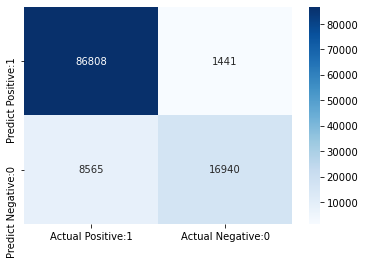

In [54]:
sns.heatmap(RandomForest_train_cm, annot=True, fmt='d', cmap='Blues')
print('RandomForest_train')

RandomForest_test


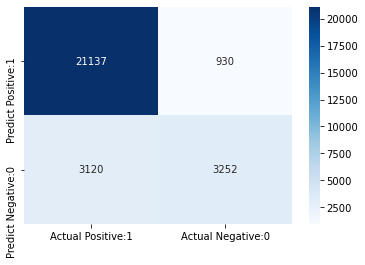

In [55]:
sns.heatmap(RandomForest_test_cm, annot=True, fmt='d', cmap='Blues')
print('RandomForest_test')

<h1>SVC<br>!!!NEED A LOT OF TIME!!!<\h1> 

In [56]:
from datetime import datetime
now = datetime.now()
print("now =", now)

now = 2021-01-07 02:31:50.369979


In [57]:
SVC_model,SVC_train_cm,SVC_test_cm = TrainAndTestModel(SVC(verbose=True), X_train, y_train, X_test, y_test, "SVC",want_fit_model=True)

[LibSVM]train_cm:  
 [[85559  2690]
 [10872 14633]] 

test_cm:  
 [[21137   930]
 [ 2979  3393]] 

train_acc:  0.8807778188019761
test_acc:  0.8625479095608144


In [58]:
now = datetime.now()
print("now =", now)

now = 2021-01-07 03:14:36.255770


SVC_train


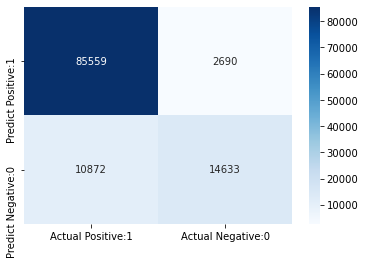

In [59]:
sns.heatmap(SVC_train_cm, annot=True, fmt='d', cmap='Blues')
print('SVC_train')

SVC_test


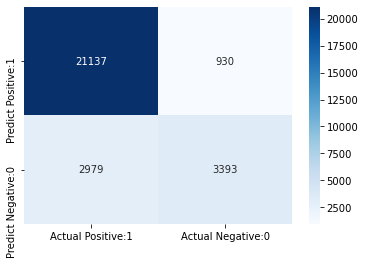

In [60]:
sns.heatmap(SVC_test_cm, annot=True, fmt='d', cmap='Blues')
print('SVC_test')

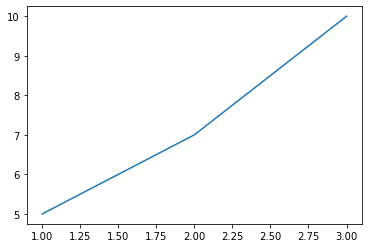

In [2]:
px = [1, 2, 3]
py = [5, 7, 10]
plt.plot(px, py)
plt.show()